<a href="https://colab.research.google.com/github/ridhima48/imdb-sentiment-bilstm-glove/blob/main/Code_for_BiLSTM_%2B_GloVe.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install kaggle

In [ ]:
import os
import json

from zipfile import ZipFile

import numpy as np
import pandas as pd
import re
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split



In [ ]:
kaggle_dictionary = json.load(open('kaggle.json'))

In [ ]:
os.environ['KAGGLE_USERNAME'] = kaggle_dictionary['username']
os.environ['KAGGLE_KEY'] = kaggle_dictionary['key']

In [ ]:
!kaggle datasets download -d lakshmi25npathi/imdb-dataset-of-50k-movie-reviews

Dataset URL: https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews
License(s): other


In [ ]:
!ls

imdb-dataset-of-50k-movie-reviews.zip  kaggle.json  sample_data


In [ ]:
with ZipFile('imdb-dataset-of-50k-movie-reviews.zip', 'r') as zip_ref:
   zip_ref.extractall()

In [ ]:

df = pd.read_csv('IMDB Dataset.csv')
df['sentiment'] = df['sentiment'].map({'positive': 1, 'negative': 0})

def clean_text(text):
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    return text.lower()

df['review'] = df['review'].apply(clean_text)


tokenizer = Tokenizer(num_words=20000)
tokenizer.fit_on_texts(df['review'])
sequences = tokenizer.texts_to_sequences(df['review'])
word_index = tokenizer.word_index

X = pad_sequences(sequences, maxlen=200)
y = df['sentiment'].values




In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

--2025-04-19 17:48:00--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2025-04-19 17:48:00--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2025-04-19 17:48:01--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [ ]:
embedding_index = {}

with open('glove.6B.100d.txt', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coeffs = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = coeffs


In [ ]:
embedding_matrix = np.zeros((len(word_index) + 1, 100))
for word, i in word_index.items():
    vector = embedding_index.get(word)
    if vector is not None:
        embedding_matrix[i] = vector

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



In [ ]:
model = Sequential()
model.add(Embedding(input_dim=len(word_index)+1,
                    output_dim=100,
                    weights=[embedding_matrix],
                    input_length=200,
                    trainable=False))
model.add(Bidirectional(LSTM(64, return_sequences=False)))
model.add(Dropout(0.6))
model.add(Dense(1, activation='sigmoid'))

In [ ]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ ?                      │    21,566,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,566,000 (82.27 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 21,566,000 (82.27 MB)

In [ ]:
history = model.fit(X_train, y_train, batch_size=64, epochs=7, validation_split=0.2)

Epoch 1/7
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - accuracy: 0.8729 - loss: 0.3107 - val_accuracy: 0.8681 - val_loss: 0.3050
Epoch 2/7
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - accuracy: 0.8794 - loss: 0.2924 - val_accuracy: 0.8711 - val_loss: 0.3186
Epoch 3/7
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - accuracy: 0.8839 - loss: 0.2844 - val_accuracy: 0.8770 - val_loss: 0.2951
Epoch 4/7
500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.8915 - loss: 0.2692 - val_accuracy: 0.8746 - val_loss: 0.3133
Epoch 5/7
500/500 ━━━━━━━━━━━━━━━━━━━━ 11s 20ms/step - accuracy: 0.8966 - loss: 0.2512 - val_accuracy: 0.8788 - val_loss: 0.2965
Epoch 6/7
500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - accuracy: 0.9034 - loss: 0.2391 - val_accuracy: 0.8815 - val_loss: 0.2893
Epoch 7/7
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - accuracy: 0.9113 - loss: 0.2281 - val_accuracy: 0.8808 - val_loss: 0.3025


In [ ]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.4f}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.8812 - loss: 0.2971
Test Accuracy: 0.8817


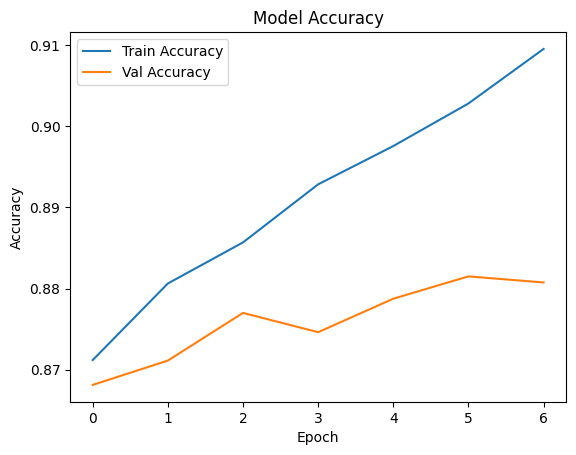

In [ ]:
import matplotlib.pyplot as plt
# Step 9: Plot Accuracy and Loss
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.legend()
plt.show()